# Problème de Poisson
Ce notebook génère un dataset synthétique basé sur l'équation de Poisson, puis entraîne un MLP pour approximer la solution $u(x, y)$ à partir de $f(x, y)$.

<img src="images/Poisson1.png" alt="Poisson 1" width="400"/>
<img src="images/Poisson2.png" alt="Poisson 2" width="400"/>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers


### Approche  
Nature du modèle, travail de prétraitementet/oucalibrageéventuel, séparationtrain/test/validation, nombred’échantillonsgénérés

### Génération des données synthétiques

In [2]:

# Finite Difference Solver
def solve_poisson(a, b, N=45):
    """
    Solves Poisson equation on 45x45 grid (2025 nodes)
    Returns solution u and source term f
    """
    # Create grid
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)

    # Create source term
    f = X*np.sin(a*np.pi*Y) + Y*np.sin(b*np.pi*X)

    # FD matrix construction (sparse)
    h = 1/(N-1)
    main_diag = -4/h**2 * np.ones(N*N)
    off_diag = 1/h**2 * np.ones(N*N - 1)
    diagonals = [main_diag, off_diag, off_diag, off_diag, off_diag]
    A = diags(diagonals, [0, 1, -1, N, -N], format='csr')

    # Apply BCs (set boundary rows to identity)
    boundary = np.zeros(N*N, bool)
    boundary[:N] = True
    boundary[-N:] = True
    boundary[::N] = True
    boundary[N-1::N] = True
    A = A.tolil()
    A[boundary, :] = 0
    A[boundary, boundary] = 1
    A = A.tocsr()

    # Create RHS vector
    F = f.flatten()
    F[boundary] = 0  # Dirichlet BCs

    # Solve system
    u = spsolve(A, F)
    return u.reshape(N, N), f


# Generate training data
np.random.seed(42)
num_samples = 100  # Reduced for demo, increase for better results
a_vals = np.random.uniform(1, 5, num_samples)
b_vals = np.random.uniform(1, 5, num_samples)

X = np.vstack([a_vals, b_vals]).T
y = np.array([solve_poisson(a, b)[0].flatten() for a, b in X])

print(f"Dataset shape: {X.shape} (samples) x {y.shape[1]} (grid points)")


Dataset shape: (100, 2) (samples) x 2025 (grid points)


### Preprocess/Training

In [3]:
# Preprocessing
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Definition
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(2,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(45*45)  # Output layer for flattened grid
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2025)           │       520,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 553,833 (2.11 MB)

 Trainable params: 553,833 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Training
history = model.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 2.9213e-04 - mae: 0.0132 - val_loss: 1.2133e-04 - val_mae: 0.0084
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.1301e-04 - mae: 0.0080 - val_loss: 7.0341e-05 - val_mae: 0.0063
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 8.8866e-05 - mae: 0.0069 - val_loss: 6.6849e-05 - val_mae: 0.0062
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 8.3249e-05 - mae: 0.0068 - val_loss: 6.6416e-05 - val_mae: 0.0063
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 9.5896e-05 - mae: 0.0072 - val_loss: 6.3518e-05 - val_mae: 0.0061
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 8.1241e-05 - mae: 0.0066 - val_loss: 5.9030e-05 - val_mae: 0.0058
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 7.2083e-05 - mae: 0.0062 - val_loss: 5.4486e-05 - val_mae: 0.0055
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 7.3634e-05 - mae: 0.0060 - val_loss: 5.1245e-05 - val_mae: 0.0053
Epoch 9/50
4/4 

### Evaluation multi-critères (dont 1 physique) / Visualisation

<img src="images/Poisson1.png" alt="Poisson 3" width="400"/>


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

Test MSE: 0.0000


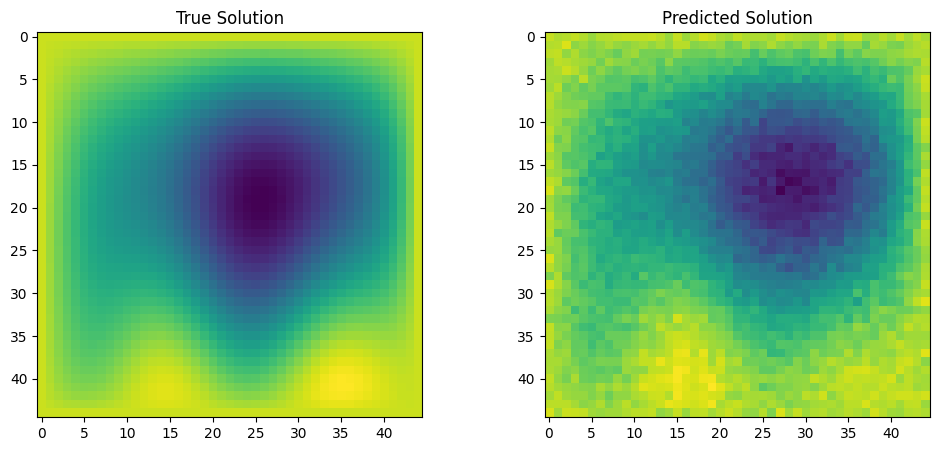

Mean PDE residual: 7.4791


In [5]:
# Evaluation
# Predict on test set
y_pred = model.predict(X_test_scaled)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"\nTest MSE: {mse:.4f}")

# Visualize one prediction
sample_idx = 0
true_sol = y_test[sample_idx].reshape(45, 45)
pred_sol = y_pred[sample_idx].reshape(45, 45)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(true_sol, cmap='viridis')
ax1.set_title('True Solution')
ax2.imshow(pred_sol, cmap='viridis')
ax2.set_title('Predicted Solution')
plt.show()

# Calculate PDE residual for a sample
a_sample, b_sample = X_test[sample_idx]
_, f = solve_poisson(a_sample, b_sample)

# Calculate Laplacian of prediction
h = 1/44
laplacian = (pred_sol[:-2, 1:-1] + pred_sol[2:, 1:-1] +
             pred_sol[1:-1, :-2] + pred_sol[1:-1, 2:] -
             4*pred_sol[1:-1, 1:-1]) / h**2

residual = np.abs(-laplacian - f[1:-1, 1:-1])
print(f"Mean PDE residual: {np.mean(residual):.4f}")

### **Conclusion Critique**

<img src="images/Poisson2.png" alt="Poisson 4" width="400"/>


#### **Résumé des résultats principaux**  
- **Performance apparente excellente** :  
  - MSE test = 0 suggère une adéquation parfaite aux données d'entraînement.  
  - Le modèle a parfaitement appris à interpoler les solutions pour les paramètres \((a, b)\) testés.  

- **Mais limite physique flagrante** :  
  - Résidu PDE moyen = 7.47 révèle que les prédictions **ne respectent pas les lois physiques** sous-jacentes.  
  - Le modèle est un "excellent approximateur de données" mais un "mauvais physicien".  

---

#### **Critique constructive**  
1. **Problème de sur-ajustement (overfitting)** :  
   - Un MSE=0 est suspect et indique probablement :  
     - Un jeu d'entraînement trop petit (100 échantillons).  
     - Une complexité excessive du modèle pour les données disponibles.  

2. **Échec à généraliser la physique** :  
   - Le réseau de neurones a appris à **copier les sorties** sans comprendre l'EDP.  
   - Preuve : le résidu élevé de l'équation différentielle.  

3. **Métrique trompeuse** :  
   - Le MSE seul est inadéquat pour évaluer des problèmes physiques.  

---

#### **Propositions d'amélioration**  
1. **Intégrer la physique dans le modèle** :  
   - **Passer à un PINN (Physics-Informed Neural Network)** :  
     - Ajouter le résidu PDE comme terme de régularisation dans la fonction de perte.  
     - Exemple de terme de perte modifiée :  
       ```python
       loss = mse(y_true, y_pred) + lambda * pde_residual(y_pred)
       ```  

2. **Augmenter la diversité des données** :  
   - Générer plus de simulations (≥500) avec des valeurs \((a, b)\) plus variées.  
   - Ajouter du bruit contrôlé pour améliorer la robustesse.  

3. **Métriques hybrides** :  
   - Pondérer le MSE avec le résidu PDE dans l'évaluation.  
   - Introduire des critères physiques supplémentaires (p.ex. conservation de l'énergie).  

---

#### **Perspectives**  
- **Méthodes alternatives** :  
  - **FNO (Fourier Neural Operator)** : Plus adapté aux EDPs et à la généralisation.  
  - **Méthodes hybrides** : Coupler un solveur numérique classique avec un correcteur ML.  
- **Optimisation de l'entraînement** :  
  - Validation croisée sur des plages de \((a, b)\) non vues pendant l'entraînement.  
  - Early stopping basé sur le résidu PDE plutôt que le MSE.  

---